# 13 - Doubles Différences

## Trois Panneaux Publicitaires dans le Sud du Brésil

Je me souviens, lorsque je travaillais dans le marketing, qu'une excellente façon de faire de la publicité était via internet. Non seulement parce que c'est très efficace (même si ça l'est), mais surtout parce qu'il est très facile de savoir si c'est réellement efficace ou non. Avec le marketing en ligne, vous pouvez savoir quels clients ont vu l'annonce, les suivre avec des cookies pour voir s'ils ont fini par visiter votre page de destination ou cliquer sur un bouton de téléchargement. Vous pouvez également utiliser le machine learning pour trouver des prospects très similaires à vos clients et ne leur présenter l'annonce qu'à eux. En ce sens, le marketing en ligne est très précis : vous ciblez uniquement ceux que vous souhaitez atteindre et vous pouvez voir s'ils réagissent comme vous le souhaitez.

Mais tout le monde n'est pas réceptif au marketing en ligne. Parfois, vous devez recourir à des techniques moins précises, comme une campagne télévisée ou l'installation d'un panneau publicitaire au coin de la rue. En général, la diversité des canaux de marketing est quelque chose que recherchent les départements de marketing. Mais si le marketing en ligne est une canne à pêche professionnelle pour attraper ce type spécifique de thon, les panneaux publicitaires et la télévision sont des filets géants que vous lancez dans un banc de poissons en espérant attraper au moins quelques gros poissons. Un autre problème avec les publicités sur panneaux publicitaires et à la télévision est qu'il est beaucoup plus difficile de savoir à quel point elles sont efficaces. Bien sûr, vous pourriez mesurer le volume d'achats, ou tout autre indicateur souhaité, avant et après avoir installé un panneau publicitaire quelque part. Si vous observez une augmentation, cela peut être une preuve que le marketing est efficace. Mais comment savoir si cette augmentation n'est pas simplement due à une tendance naturelle dans la notoriété de votre produit ? En d'autres termes, comment sauriez-vous le contrefactuel $Y_0$, c'est-à-dire ce qui se serait passé si vous n'aviez pas installé les panneaux publicitaires en premier lieu ?

![img](./data/img/diff-in-diff/secrets.png)

Une technique pour répondre à ce type de question est la méthode des doubles différences (*difference-in-difference* en anglais), ou diff-in-diff pour les intimes. La méthode diff-in-diff est couramment utilisée pour évaluer l'effet d'interventions macro, comme l'effet de l'immigration sur le chômage, l'effet des changements dans les lois sur les armes à feu sur les taux de criminalité, ou simplement la différence d'engagement des utilisateurs due à une campagne marketing. Dans tous ces cas, vous avez une période avant et après l'intervention, et vous souhaitez démêler l'impact de l'intervention d'une tendance générale. Pour illustrer, prenons un exemple similaire à celui auquel j'ai dû répondre.

Pour déterminer l'efficacité des panneaux publicitaires en tant que canal marketing, nous avons installé 3 panneaux dans la ville de Porto Alegre, la capitale de l'État du Rio Grande do Sul. Nous voulions voir si cela augmentait les dépôts sur nos comptes d'épargne. Pour ceux qui ne sont pas très familiers avec la géographie brésilienne, le Rio Grande do Sul fait partie du sud du pays, l'une des régions les plus développées.

En gardant cela à l'esprit, nous avons décidé d'examiner également les données d'une autre capitale du sud, Florianopolis, la capitale de l'État de Santa Catarina. L'idée était d'utiliser Florianopolis comme échantillon de contrôle pour estimer le contrefactuel $Y_0$ en comparaison avec Porto Alegre (au passage, ce n'était pas l'expérience réelle, qui est confidentielle, mais l'idée est très similaire). Nous avons installé les panneaux publicitaires à Porto Alegre pendant tout le mois de juin. Les données dont nous disposons ressemblent à ceci :

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


%matplotlib inline

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("data/billboard_impact.csv")
data.head()

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


Rappelons que les dépôts sont notre variable de résultat, celle que nous souhaitons augmenter grâce aux panneaux publicitaires. "POA" est un indicateur binaire pour la ville de Porto Alegre. Lorsqu'il est égal à zéro, cela signifie que les échantillons proviennent de Florianopolis. "Jul" est un indicateur binaire pour le mois de juillet, ou pour la période post-intervention. Lorsqu'il est égal à zéro, cela se réfère aux échantillons de mai, la période pré-intervention.

## Estimateur DID

Pour éviter toute confusion entre le temps et le traitement, je vais désormais utiliser D pour désigner le traitement et T pour désigner le temps. Soit $Y_D(T)$ le résultat potentiel pour le traitement D à la période T. Dans un monde idéal où nous pourrions observer le contrefactuel, nous estimerions l'effet du traitement d'une intervention de la manière suivante :

$$
\hat{ATET} = E[Y_1(1) - Y_0(1)|D=1]
$$

En d'autres termes, l'effet causal est le résultat observé dans la période post-intervention en cas de traitement, moins le résultat observé également dans la période post-intervention, mais dans le cas où il n'y a pas eu de traitement. Bien sûr, nous ne pouvons pas mesurer cela car $Y_0(1)$ est contrefactuel.

Une façon de contourner ce problème est de faire une comparaison avant-après :

$$
\hat{ATET} = E[Y(1)|D=1] - E[Y(0)|D=1]
$$

Dans notre exemple, nous comparerions les dépôts moyens à Porto Alegre avant et après l'installation des panneaux publicitaires.

In [3]:
poa_before = data.query("poa==1 & jul==0")["deposits"].mean()

poa_after = data.query("poa==1 & jul==1")["deposits"].mean()

poa_after - poa_before

41.04775

Cet estimateur nous indique que nous devrions nous attendre à une augmentation des dépôts de 41,04 R$ après l'intervention. Mais peut-on vraiment se fier à cette estimation ?

Remarquez que $E[Y(0)|D=1]=E[Y_0(0)|D=1]$, c'est-à-dire que le résultat observé pour l'unité traitée **avant l'intervention** est égal au résultat contrefactuel pour l'unité traitée également avant l'intervention. Comme nous utilisons cette information pour estimer le résultat contrefactuel **après l'intervention** $E[Y_0(1)|D=1]$, cette estimation suppose que $E[Y_0(1)|D=1] = E[Y_0(0)|D=1]$.

En d'autres termes, cela revient à dire qu'en l'absence d'intervention, le résultat de la période suivante serait identique à celui de la période initiale. Cela serait évidemment faux si votre variable de résultat suit une quelconque tendance. Par exemple, si les dépôts augmentent à Porto Alegre, alors $E[Y_0(1)|D=1] > E[Y_0(0)|D=1]$, c'est-à-dire que le résultat de la période suivante serait supérieur à celui de la période initiale même en l'absence d'intervention. De la même manière, si la tendance de Y est à la baisse, $E[Y_0(1)|D=1] < E[Y_0(0)|D=1]$. Cela montre que cette méthode avant-après n'est pas un excellent estimateur.

Une autre idée serait de comparer le groupe traité à un groupe non traité qui n'a pas reçu l'intervention :

$$
\hat{ATET} = E[Y(1)|D=1] - E[Y(1)|D=0]
$$

Dans notre exemple, cela reviendrait à comparer les dépôts à Porto Alegre à ceux de Florianopolis pendant la période post-intervention.

In [4]:
fl_after = data.query("poa==0 & jul==1")["deposits"].mean()
poa_after - fl_after

-119.10175000000001

Cet estimateur nous indique que la campagne est préjudiciable et que les clients diminueront leurs dépôts de 119,10 R$. 

Remarquez que $E[Y(1)|D=0]=E[Y_0(1)|D=0]$. Et comme nous utilisons $E[Y(1)|D=0]$ pour estimer le contrefactuel pour les traités après l'intervention, nous supposons que nous pouvons remplacer le contrefactuel manquant ainsi : $E[Y_0(1)|D=0] = E[Y_0(1)|D=1]$. Mais cela ne serait vrai que si les deux groupes avaient un niveau de référence très similaire. Par exemple, si Florianopolis a beaucoup plus de dépôts que Porto Alegre, cela ne serait pas vrai car $E[Y_0(1)|D=0] > E[Y_0(1)|D=1]$. D'un autre côté, si le niveau des dépôts est plus faible à Florianopolis, nous aurions $E[Y_0(1)|D=0] < E[Y_0(1)|D=1]$.

Encore une fois, ce n'est pas une excellente idée. Pour résoudre ce problème, nous pouvons utiliser à la fois la comparaison dans l'espace et dans le temps. C'est l'idée de l'approche des doubles différences. Elle fonctionne en remplaçant le contrefactuel manquant de la manière suivante :

$$
E[Y_0(1)|D=1] = E[Y_0(0)|D=1] + (E[Y_0(1)|D=0] - E[Y_0(0)|D=0])
$$

Ce que cela fait, c'est prendre l'unité traitée **avant l'intervention** et y ajouter une composante de tendance, qui est estimée en utilisant le contrôle $E[Y_0(1)|D=0] - E[Y_0(0)|D=0]$. En d'autres termes, cela dit que les traités **après l'intervention**, s'ils n'avaient pas été traités, ressembleraient aux **traités avant le traitement** plus un facteur de croissance qui est le même que celui du groupe de contrôle.

Il est important de noter que cela suppose que les tendances dans le groupe de traitement et le groupe de contrôle sont les mêmes :

$$
E[Y_0(1) − Y_0(0)|D=1] = E[Y_0(1) − Y_0(0)|D=0]
$$

où le côté gauche représente la tendance contrefactuelle. Maintenant, nous pouvons remplacer le contrefactuel estimé dans la définition de l'effet du traitement $E[Y_1(1)|D=1] - E[Y_0(1)|D=1]$

$$
\hat{ATET} = E[Y(1)|D=1] - (E[Y(0)|D=1] + (E[Y(1)|D=0] - E[Y(0)|D=0]))
$$

Si nous réarrangeons les termes, nous obtenons l'estimateur classique des doubles différences.

$$
\hat{ATET} = (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0])
$$

Il porte ce nom parce qu'il calcule la double différence entre le traitement et le contrôle après et avant le traitement.

Voici à quoi cela ressemble en code.

In [5]:
fl_before = data.query("poa==0 & jul==0")["deposits"].mean()

diff_in_diff = (poa_after-poa_before)-(fl_after-fl_before)
diff_in_diff

6.524557692307688

La méthode Diff-in-Diff nous indique que nous devrions nous attendre à une augmentation des dépôts de R$ 6,52 par client. Remarquez que l'hypothèse que fait la méthode Diff-in-Diff est beaucoup plus plausible que celle des deux autres estimateurs. Elle suppose simplement que le modèle de croissance entre les deux villes est le même. Mais elle ne nécessite pas qu'elles aient le même niveau de base ni que la tendance soit nulle.

Pour visualiser ce que fait la méthode Diff-in-Diff, nous pouvons projeter la tendance de croissance du groupe non traité sur le groupe traité pour voir le contrefactuel, c'est-à-dire le nombre de dépôts auquel nous devrions nous attendre s'il n'y avait pas eu d'intervention.

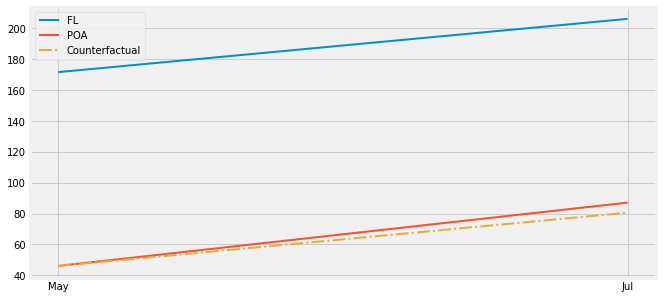

In [6]:
plt.figure(figsize=(10,5))
plt.plot(["May", "Jul"], [fl_before, fl_after], label="FL", lw=2)
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

Voyez-vous cette petite différence entre les lignes pointillées rouges et jaunes ? Si vous vous concentrez vraiment, vous pouvez apercevoir l'effet modeste du traitement sur Porto Alegre.

![img](./data/img/diff-in-diff/cant-read.png)

Maintenant, vous vous demandez peut-être : "À quel point puis-je faire confiance à cet estimateur ? J'ai le droit d'avoir des erreurs standard rapportées !". Ce qui est tout à fait légitime, car les estimateurs sans erreurs standard paraissent incomplets. Pour ce faire, nous allons utiliser une astuce astucieuse qui implique la régression. Plus précisément, nous allons estimer le modèle linéaire suivant :

$$
Y_i = \beta_0 + \beta_1 POA_i + \beta_2 Jul_i + \beta_3 POA_i*Jul_i + e_i
$$

Remarquez que $\beta_0$ est la base de référence du groupe de contrôle. Dans notre cas, c'est le niveau des dépôts à Florianopolis au mois de mai. Si nous activons la variable binaire pour la ville traitée, nous obtenons $\beta_1$. Ainsi, $\beta_0 + \beta_1$ représente le niveau de référence de Porto Alegre en mai, avant l'intervention, et $\beta_1$ est l'augmentation du niveau de référence de Porto Alegre par rapport à celui de Florianopolis. Si nous désactivons la variable binaire POA et activons la variable binaire pour juillet, nous obtenons $\beta_0 + \beta_2$, qui correspond au niveau de Florianópolis en juillet, après la période d'intervention. $\beta_2$ représente donc la tendance du groupe de contrôle, puisqu'on l'ajoute à la base de référence pour obtenir le niveau du groupe de contrôle après l'intervention. Pour récapituler, $\beta_1$ est l'incrément que nous obtenons en passant du groupe de contrôle au groupe traité, $\beta_2$ est l'incrément que nous obtenons en passant de la période avant l'intervention à la période après l'intervention. Enfin, si nous activons les deux variables binaires, nous obtenons $\beta_3$. $\beta_0 + \beta_1 + \beta_2 + \beta_3$ représente le niveau à Porto Alegre après l'intervention. Ainsi, $\beta_3$ est l'impact incrémental lorsque l'on passe de mai à juillet et de Florianopolis à Porto Alegre. En d'autres termes, c'est l'estimateur de la Différence en Différences.

Si vous ne me croyez pas, vérifiez par vous-même. Vous devriez obtenir exactement le même chiffre que celui que nous avons calculé plus haut. Et remarquez aussi comment nous obtenons enfin nos erreurs standard tant attendues.

In [7]:
smf.ols('deposits ~ poa*jul', data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


## Tendances Non Parallèles

Un problème évident avec la méthode Diff-in-Diff est l'échec à satisfaire l'hypothèse de tendances parallèles. Si la tendance de croissance du groupe traité est différente de celle du groupe de contrôle, la méthode Diff-in-Diff sera biaisée. C'est un problème courant avec des données non aléatoires, où la décision de traiter une région est basée sur son potentiel à bien répondre au traitement, ou lorsque le traitement est ciblé sur des régions qui ne se portent pas très bien. Prenons notre exemple de marketing. Nous avons décidé de tester les panneaux publicitaires à Porto Alegre non pas pour vérifier l'effet des panneaux publicitaires en général, mais simplement parce que les ventes y sont médiocres. Peut-être que le marketing en ligne ne fonctionne pas bien là-bas. Dans ce cas, il pourrait être que la croissance que nous aurions vue à Porto Alegre sans panneaux publicitaires aurait été inférieure à celle observée dans d'autres villes. Cela nous amènerait à sous-estimer l'effet du panneau publicitaire.

Une façon de vérifier si cela se produit est de tracer la tendance en utilisant des périodes passées. Par exemple, supposons que POA avait une petite tendance à la baisse tandis que Florianopolis était en forte croissance. Dans ce cas, montrer des périodes antérieures révélerait ces tendances, et nous saurions que la méthode Diff-in-Diff n'est pas un estimateur fiable.

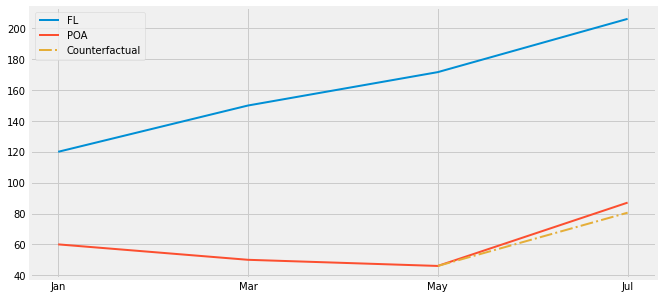

In [18]:
plt.figure(figsize=(10,5))
x = ["Jan", "Mar", "May", "Jul"]

plt.plot(x, [120, 150, fl_before,  fl_after], label="FL", lw=2)
plt.plot(x, [60, 50, poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

Nous verrons comment résoudre ce problème avec le contrôle synthétique. Cette méthode utilisera plusieurs villes pour créer une ville synthétique qui suit de près la tendance de la ville d'intérêt. Mais pour l'instant, rappelez-vous qu'il est toujours nécessaire de vérifier si vous avez des tendances parallèles lorsque vous appliquez la méthode Diff-in-Diff.

![img](./data/img/diff-in-diff/non-parallel.png)

Un dernier point à mentionner est que vous ne pourrez pas placer d'intervalles de confiance autour de votre estimateur Diff-in-Diff si vous ne disposez que de données agrégées. Supposons, par exemple, que vous n'ayez pas de données sur ce que chaque client de Florianópolis ou de Porto Alegre a fait. Au lieu de cela, vous avez seulement les dépôts moyens avant et après l'intervention pour les deux villes. Dans ce cas, vous pourrez toujours estimer l'effet causal avec la méthode Diff-in-Diff, mais vous ne connaîtrez pas la variance de cette estimation. En effet, toute la variabilité de vos données a été écrasée lors de l'agrégation.

## Idées Clés

Nous avons exploré une technique largement utilisée lorsque nous estimons des effets causaux à des niveaux plus macro (écoles, villes, États, pays...). La méthode des doubles différences compare une unité traitée avant et après le traitement à la tendance du résultat d'une unité de contrôle. Ici, nous avons vu comment cela pourrait être appliqué pour estimer l'effet d'une campagne marketing spécifique à une ville.

Enfin, nous avons examiné comment la méthode Diff-in-Diff échoue si la tendance entre l'unité traitée et l'unité de contrôle n'est pas la même. Nous avons également vu que la méthode Diff-in-Diff sera problématique si nous ne disposons que de données agrégées.

## Références

J'aime penser à ce livre entier comme un hommage à Joshua Angrist, Alberto Abadie et Christopher Walters pour leur incroyable cours d'économétrie. La plupart des idées ici sont tirées de leurs cours à l'American Economic Association. Les regarder est ce qui me maintient sain d'esprit pendant cette année difficile de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Je tiens également à référencer les livres incroyables d'Angrist. Ils m'ont montré que l'économétrie, ou 'Metrics' comme ils l'appellent, n'est pas seulement extrêmement utile mais aussi profondément amusante.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Ma dernière référence est le livre de Miguel Hernan et Jamie Robins. Il a été mon compagnon fidèle dans les questions causales les plus épineuses que j'ai dû résoudre.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Les données utilisées ici proviennent d'une étude de Alpert, William T., Kenneth A. Couch, et Oskar R. Harmon. 2016. ["A Randomized Assessment of Online Learning"](https://www.aeaweb.org/articles?id=10.1257/aer.p20161057). American Economic Review, 106 (5): 378-82.

![img](./data/img/poetry.png)

## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).